<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment9/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Load Data
<hr>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [4]:
data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
batch_32 = 32
batch_64 = 64
batch_128 = 128
learning_rate_value = 1e-2

In [6]:
train_loader_32 = DataLoader(dataset = training_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader_32 = DataLoader(dataset = testing_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 test loader 생성

train_loader_64 = DataLoader(dataset = training_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 train loader 생성
test_loader_64 = DataLoader(dataset = testing_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 test loader 생성

train_loader_128 = DataLoader(dataset = training_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 train loader 생성
test_loader_128 = DataLoader(dataset = testing_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 test loader 생성



Target: 6


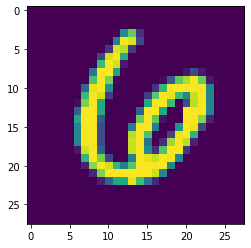

In [7]:
for X, Y in train_loader_32:
  plt.imshow(X[0][0].numpy())
  print(f"Target: {Y[0]}")
  break

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [9]:
classifier_32 = classification().to(device)
classifier_64 = classification().to(device)
classifier_128 = classification().to(device)

In [10]:
## Loss function
criterion = nn.NLLLoss()

# Optimization
optimizer = torch.optim.SGD(classifier_32.parameters(), lr=learning_rate_value)

# 4. Training
<hr>

In [11]:
training_epochs = 60
total_batch_32 = len(train_loader_32)
total_batch_64 = len(train_loader_64)
total_batch_128 = len(train_loader_128)

In [15]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [16]:
def training(model, loss, optim, training_epochs, total_batch, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    for (X, Y), (X_test, Y_test) in zip(train_loader, test_loader):
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()
      total_cost_train += cost

      acc_train = accuracy(train_pred, Y)
      accuracy_train.append(acc_train)
      with torch.no_grad():
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        acc_test = accuracy(test_pred, Y_test)
        accuracy_test.append(acc_test)

    avg_cost_train = total_cost_train / total_batch
    avg_cost_test = total_cost_test / total_batch

    L_iters_train.append(avg_cost_train)
    L_iters_test.append(avg_cost_test)
    
    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, acc_train, acc_test))
  return L_iters_train, accuracy_train

In [17]:
L_32, A_32 = training(classifier_32, criterion, optimizer, training_epochs, total_batch_32, train_loader_32, test_loader_32)

Epoch: 01 Training Loss: 0.383255273 Testing Loss: 0.383502215  Training Acc: 0.125000000 Testing Acc: 0.000000000
Epoch: 02 Training Loss: 0.378455073 Testing Loss: 0.378414869  Training Acc: 0.187500000 Testing Acc: 0.125000000
Epoch: 03 Training Loss: 0.372752905 Testing Loss: 0.372601479  Training Acc: 0.281250000 Testing Acc: 0.312500000
Epoch: 04 Training Loss: 0.363002837 Testing Loss: 0.362792581  Training Acc: 0.375000000 Testing Acc: 0.625000000
Epoch: 05 Training Loss: 0.345448971 Testing Loss: 0.345580041  Training Acc: 0.593750000 Testing Acc: 0.250000000
Epoch: 06 Training Loss: 0.319076926 Testing Loss: 0.317851782  Training Acc: 0.687500000 Testing Acc: 0.687500000
Epoch: 07 Training Loss: 0.283037275 Testing Loss: 0.280996591  Training Acc: 0.593750000 Testing Acc: 0.625000000
Epoch: 08 Training Loss: 0.245846242 Testing Loss: 0.244556859  Training Acc: 0.687500000 Testing Acc: 0.687500000
Epoch: 09 Training Loss: 0.214786291 Testing Loss: 0.214489684  Training Acc: 0.

NameError: ignored

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(L_32)

tensor(6, device='cuda:0')


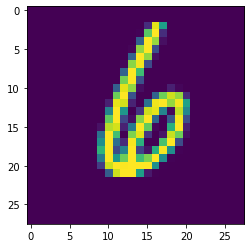

In [21]:
for X, Y in test_loader_32:
    plt.imshow(X[0][0].numpy())
    X_1 = X.to(device)
    pred = classifier_32(X_1)
    print(torch.argmax(pred[0]))
    break